# Lab-02 From Crossvalidation to  GridSearch with KKN Classification and Regression

## Goals of this lab
1. Explore K Nearest Neighbors 
* Review  K-fold cross-validation
   * parameter tuning using cross_val_score
* Introduce GridSearchCV(a more efficient form parameter tuning)
   * Searching multiple parameters simultaneously
* Introduce pipelines as means of setting up workflows that can be repeated easily
   * these pipelines can be used in GridSearches in the case of classification or regression
* Present a casestudy of hyperparameter tuning for classification 
   * Pipelines
   * Gridsearch
   * Cross validation
   * Held out test dataset
* Utility maximization via Gridsearch (maximize utility == minimize MSE)
* Task: complete a casestudy of hyperparameter tuning for regression


##  References
This lab is derived from Data School's Machine Learning with scikit-learn tutorial. 

* From the video series: [Introduction to machine learning with scikit-learn](https://github.com/justmarkham/scikit-learn-videos)
* [Ritchie Ng's Blog](http://www.ritchieng.com/machine-learning-efficiently-search-tuning-param) 


## An End-to-end Machine Learning pipeline


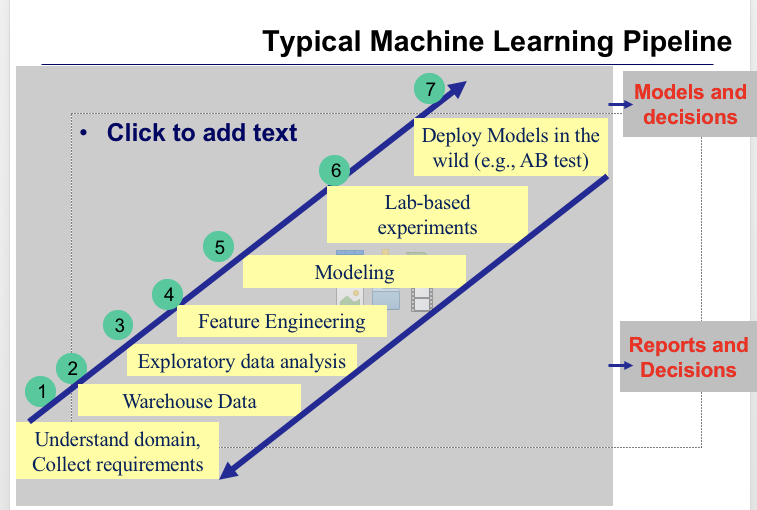

# Cross Validation
*From the video series: [Introduction to machine learning with scikit-learn](https://github.com/justmarkham/scikit-learn-videos)*

## Agenda

- Exploring the KNN Algorithm
- What is the drawback of using the **train/test split** procedure for model evaluation?
- How does **K-fold cross-validation** overcome this limitation?
- How can cross-validation be used for selecting **tuning parameters**, choosing between **models**, and selecting **features**?
- What are some possible **improvements** to cross-validation?

# KNN Review in Code

## Visualize the Iris data (with k=3 v. k=5)

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import numpy as np

In [2]:
# read in the iris data
iris = load_iris()

# create X (features) and y (response)
X = iris.data
y = iris.target

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.5, random_state=4)

# select sepal features only (for easier 2D visualization)
sepal_train = X_train[:,:2]
sepal_test = X_test[:,:2]

In [3]:
# generate predictions (based on 3 nearest neighbors)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(sepal_train, y_train)
preds3 = knn.predict(sepal_test)

# generate predictions (based on 5 nearest neighbors)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(sepal_train, y_train)
preds5 = knn.predict(sepal_test)

In [4]:
# select a few examples that were predicted differently by each model
class_change = np.where((preds3-preds5)!=0)
example_width = sepal_test[class_change][:,1]
example_length = sepal_test[class_change][:,0]

In [5]:
# assign a color to each class
class_colors = {0:'purple', 1:'blue', 2:'green'}

# map colors to true class data 
true_colors = [class_colors[x] for x in y_train]
examples_true_color = [class_colors[x] for x in y_test[class_change]]
                  
# map colors to predicted classes (for knn=3 and knn=5)
preds3_examples = preds3[class_change]
preds3_example_colors = [class_colors[x] for x in preds3_examples]

preds5_examples = preds5[class_change]
preds5_example_colors = [class_colors[x] for x in preds5_examples]


In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

# generate legend patches
setosa = mpatches.Patch(color='purple', label='Setosa')
versicolour = mpatches.Patch(color='green', label='Versicolour')
virginica = mpatches.Patch(color='blue', label='Virginica')

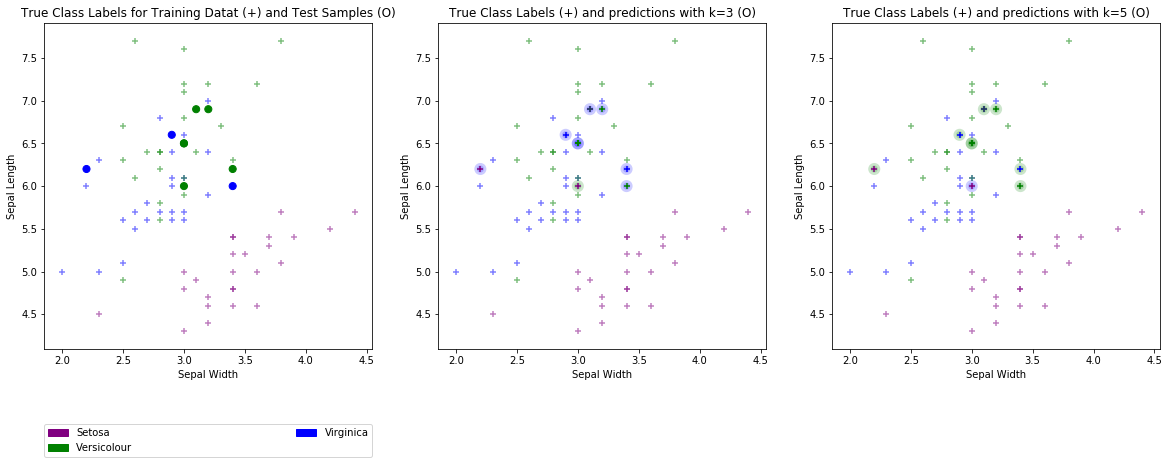

In [13]:
###### plot true class for all data
fig, ax = plt.subplots(1,3,figsize=(20,6), sharex=True, sharey=True)

# first subplot (all training data)
ax[0].scatter(sepal_train[:,1], sepal_train[:,0], c=true_colors, marker='+', alpha=.5)
ax[0].scatter(example_width, example_length, marker="o", s=50, c=examples_true_color)
ax[0].set_title('True Class Labels for Training Datat (+) and Test Samples (O)')
ax[0].set_xlabel('Sepal Width')
ax[0].set_ylabel('Sepal Length')
ax[0].legend(handles=[setosa, versicolour, virginica], bbox_to_anchor=(0, -.33, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

# plot examples where test predictions differ
ax[1].scatter(example_width, example_length, c=preds3_example_colors, marker="o", s=50, alpha =.2, linewidths = 5)
ax[1].scatter(example_width, example_length, c=true_colors, marker="+" )
ax[1].scatter(sepal_train[:,1], sepal_train[:,0], c=true_colors, marker='+', alpha=.5)
ax[1].set_title('True Class Labels (+) and predictions with k=3 (O)')
ax[1].set_xlabel('Sepal Width')
ax[1].set_ylabel('Sepal Length')
ax[1].tick_params(labelleft=True)

ax[2].scatter(example_width, example_length, c=preds5_example_colors, marker="o", s=50, alpha =.2, linewidths = 5)
ax[2].scatter(example_width, example_length, c=true_colors, marker="+")
ax[2].scatter(sepal_train[:,1], sepal_train[:,0], c=true_colors, marker='+', alpha=.5)
ax[2].set_title('True Class Labels (+) and predictions with k=5 (O)')
ax[2].set_xlabel('Sepal Width')
ax[2].set_ylabel('Sepal Length')
ax[2].tick_params(labelleft=True);

### Examine the Iris data with KNN (k=3 and k=5)

In [582]:
# calculate euclidean distance
def metric_func(x1, x2):
    distance = np.linalg.norm(x1 - x2, ord=2, axis=1)
    return distance

examples = sepal_test[class_change]
nearest_indices = np.zeros(shape=(examples.shape[0], 5), dtype=np.int) - 1
nearest_distances = np.zeros(shape=(examples.shape[0], 5), dtype=np.float) - 1

# collect index and distance for 5 nearest neighbors
for i in range(examples.shape[0]):
    distances = metric_func(examples[i], sepal_train)
    index_order = np.argsort(distances)[:5]
    nearest_indices[i] = index_order
    nearest_distances[i] = distances[index_order]
    

In [592]:
import pandas as pd
pd.set_option('display.max_colwidth',100)
df = pd.DataFrame(columns=["Test Sample", "Nearest Points", "Euclidean Distance", "Class(es)", "Pred k=3", "Pred k=5" ])

for i in range(len(examples)):
    df.loc[i] = [examples[i], sepal_train[nearest_indices[i]], np.round(nearest_distances[i],3), 
                 y_train[nearest_indices[i]], np.argmax(np.bincount(y_train[nearest_indices[i, :3]])),
                np.argmax(np.bincount(y_train[nearest_indices[i, :5]]))]

### Examine data for test Samples
|Column Name   | Description|
|:--|:---|
|Test Data| Sample points (sepal width, sepal length) taken from the held-out test data |
|Nearest Points| Five nearest points (by Euclidean distance) from the data used to train the model |
|Euclidean Distance| Distance from the test sample to each of the five nearest points|
|Class(es)| True class(es) of the five nearest points|
|Pred k=3 | Predicted class for the test sample when k=3 |
|Pred k=5|  Predicted class for the test sample when k=5 |


In [594]:
df

,Test Sample,Nearest Points,Euclidean Distance,Class(es),Pred k=3,Pred k=5
0,"[6.9, 3.1]","[[6.9, 3.1], [6.9, 3.1], [7.0, 3.2], [6.8, 3.0], [7.1, 3.0]]","[0.0, 0.0, 0.141, 0.141, 0.224]","[1, 2, 1, 2, 2]",1,2
1,"[6.6, 2.9]","[[6.6, 3.0], [6.5, 3.0], [6.4, 2.9], [6.4, 2.8], [6.4, 2.8]]","[0.1, 0.141, 0.2, 0.224, 0.224]","[1, 2, 1, 2, 2]",1,2
2,"[6.5, 3.0]","[[6.5, 3.0], [6.6, 3.0], [6.4, 3.1], [6.4, 2.9], [6.4, 3.2]]","[0.0, 0.1, 0.141, 0.141, 0.224]","[2, 1, 2, 1, 1]",2,1
3,"[6.5, 3.0]","[[6.5, 3.0], [6.6, 3.0], [6.4, 3.1], [6.4, 2.9], [6.4, 3.2]]","[0.0, 0.1, 0.141, 0.141, 0.224]","[2, 1, 2, 1, 1]",2,1
4,"[6.2, 2.2]","[[6.3, 2.3], [6.0, 2.2], [6.3, 2.5], [6.1, 2.6], [6.4, 2.7]]","[0.141, 0.2, 0.316, 0.412, 0.539]","[1, 1, 2, 2, 2]",1,2
5,"[6.9, 3.2]","[[7.0, 3.2], [6.9, 3.1], [6.9, 3.1], [6.7, 3.3], [6.8, 3.0]]","[0.1, 0.1, 0.1, 0.224, 0.224]","[1, 1, 2, 2, 2]",1,2
6,"[6.0, 3.4]","[[5.9, 3.2], [6.3, 3.4], [6.1, 3.0], [6.1, 3.0], [5.9, 3.0]]","[0.224, 0.3, 0.412, 0.412, 0.412]","[1, 2, 2, 1, 2]",2,2
7,"[6.0, 3.0]","[[6.1, 3.0], [6.1, 3.0], [5.9, 3.0], [6.0, 2.9], [6.1, 2.9]]","[0.1, 0.1, 0.1, 0.1, 0.141]","[1, 2, 2, 1, 1]",2,1
8,"[6.2, 3.4]","[[6.3, 3.4], [6.4, 3.2], [5.9, 3.2], [6.4, 3.1], [6.1, 3.0]]","[0.1, 0.283, 0.361, 0.361, 0.412]","[2, 1, 1, 2, 1]",1,1


## Review of model evaluation procedures

**Motivation:** Need a way to choose between machine learning models

- Goal is to estimate likely performance of a model on **out-of-sample data**

**Initial idea:** Train and test on the same data

- But, maximizing **training accuracy** rewards overly complex models which **overfit** the training data

**Alternative idea:** Train/test split

- Split the dataset into two pieces, so that the model can be trained and tested on **different data**
- **Testing accuracy** is a better estimate than training accuracy of out-of-sample performance
- But, it provides a **high variance** estimate since changing which observations happen to be in the testing set can significantly change testing accuracy

In [14]:
# use train/test split with different random_state values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=4)

# check classification accuracy of KNN with K=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(metrics.accuracy_score(y_test, y_pred))

0.9736842105263158


**Question:** What if we created a bunch of train/test splits, calculated the testing accuracy for each, and averaged the results together?

**Answer:** That's the essense of cross-validation!

## Steps for K-fold cross-validation

1. Split the dataset into K **equal** partitions (or "folds").
2. Use fold 1 as the **testing set** and the union of the other folds as the **training set**.
3. Calculate **testing accuracy**.
4. Repeat steps 2 and 3 K times, using a **different fold** as the testing set each time.
5. Use the **average testing accuracy** as the estimate of out-of-sample accuracy.

Diagram of **5-fold cross-validation:**

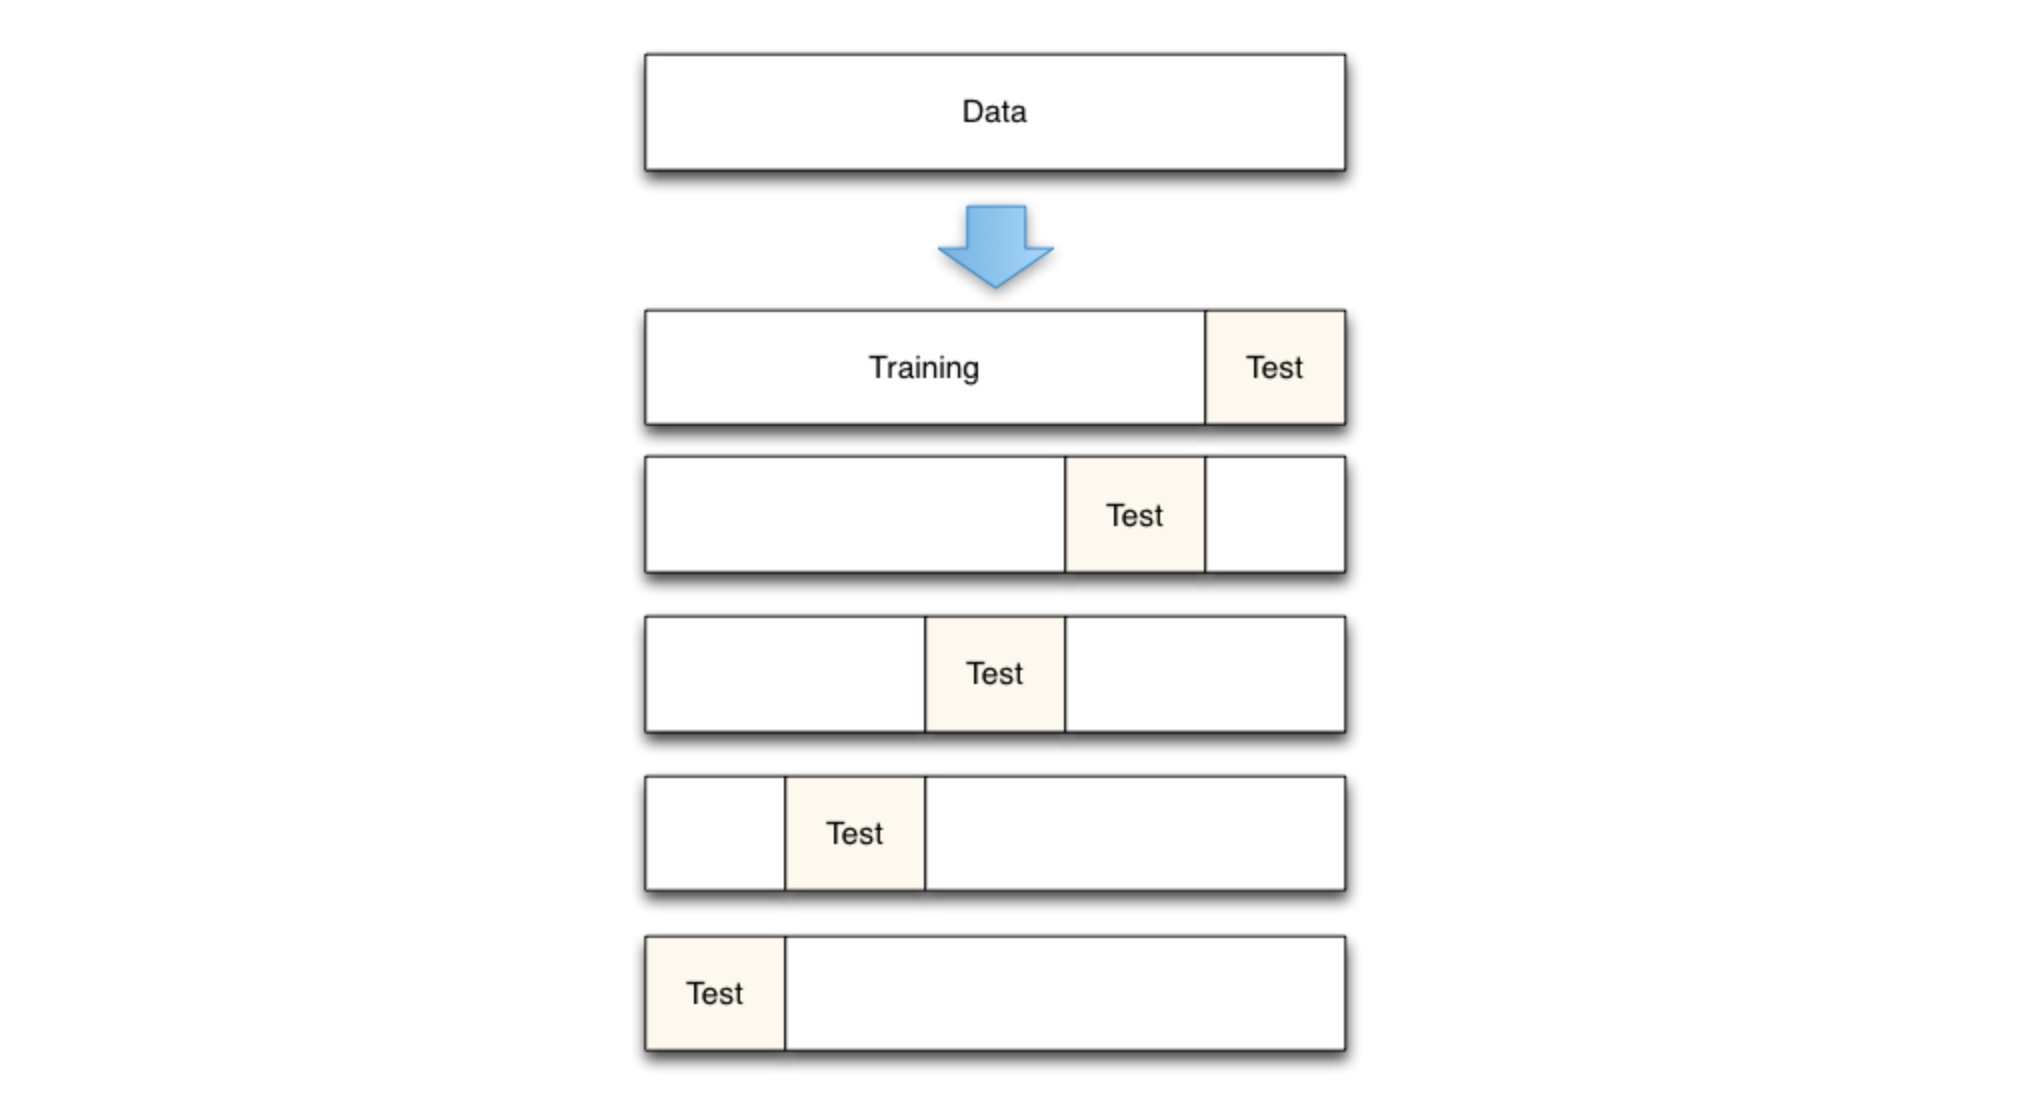


In [15]:
# simulate splitting a dataset of 25 observations into 5 folds
import numpy as np
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=False)
splits = kf.split(list(range(25)))
# print the contents of each training and testing set
print('{} {:^61} {}'.format('Iteration', 'Training set observations', 'Testing set observations'))
for iteration, data in enumerate(splits, start=1):
    print('{:^9} {} {:^25}'.format(iteration, format(str(np.array(data[0]))), format(str(np.array(data[1])))))

Iteration                   Training set observations                   Testing set observations
    1     [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]        [0 1 2 3 4]       
    2     [ 0  1  2  3  4 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]        [5 6 7 8 9]       
    3     [ 0  1  2  3  4  5  6  7  8  9 15 16 17 18 19 20 21 22 23 24]     [10 11 12 13 14]     
    4     [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 20 21 22 23 24]     [15 16 17 18 19]     
    5     [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]     [20 21 22 23 24]     


- Dataset contains **25 observations** (numbered 0 through 24)
- 5-fold cross-validation, thus it runs for **5 iterations**
- For each iteration, every observation is either in the training set or the testing set, **but not both**
- Every observation is in the testing set **exactly once**

## Comparing cross-validation to train/test split

Advantages of **cross-validation:**

- More accurate estimate of out-of-sample accuracy
- More "efficient" use of data (every observation is used for both training and testing)

Advantages of **train/test split:**

- Runs K times faster than K-fold cross-validation
- Simpler to examine the detailed results of the testing process

## Cross-validation recommendations

1. K can be any number, but **K=10** is generally recommended
2. For classification problems, **stratified sampling** is recommended for creating the folds
    - Each response class should be represented with equal proportions in each of the K folds
    - scikit-learn's `cross_val_score` function does this by default

## Cross-validation example: parameter tuning

**Goal:** Select the best tuning parameters (aka "hyperparameters") for KNN on the iris dataset


In [17]:
from sklearn.model_selection import cross_val_score

In [18]:
X.shape

(150, 4)

In [19]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print(scores)

[1.         0.93333333 1.         1.         0.86666667 0.93333333
 0.93333333 1.         1.         1.        ]


In [20]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

0.9666666666666668


In [21]:
# search for an optimal value of K for KNN
k_range = list(range(1, 31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.96, 0.9533333333333334, 0.9666666666666666, 0.9666666666666666, 0.9666666666666668, 0.9666666666666668, 0.9666666666666668, 0.9666666666666668, 0.9733333333333334, 0.9666666666666668, 0.9666666666666668, 0.9733333333333334, 0.9800000000000001, 0.9733333333333334, 0.9733333333333334, 0.9733333333333334, 0.9733333333333334, 0.9800000000000001, 0.9733333333333334, 0.9800000000000001, 0.9666666666666666, 0.9666666666666666, 0.9733333333333334, 0.96, 0.9666666666666666, 0.96, 0.9666666666666666, 0.9533333333333334, 0.9533333333333334, 0.9533333333333334]


In [22]:
import numpy as np
np.argmax(k_scores)

12

Text(0,0.5,'Cross-Validated Accuracy')

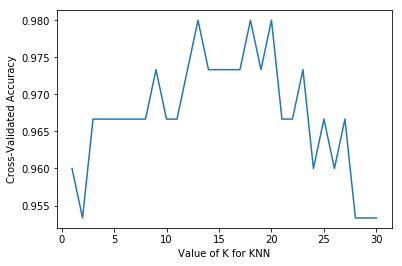

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

## Cross-validation example: model selection

**Goal:** Compare the best KNN model with logistic regression on the iris dataset

In [24]:
# 10-fold cross-validation with the best KNN model
knn = KNeighborsClassifier(n_neighbors=20)
print(cross_val_score(knn, X, y, cv=10, scoring='accuracy').mean())

0.9800000000000001


In [25]:
# 10-fold cross-validation with logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
print(cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean())

0.9533333333333334


# More efficient parameter tuning using `GridSearchCV`

Instead of managing experiments ourselves via code like this:

        # search for an optimal value of K for KNN
        k_range = list(range(1, 31))
        k_scores = []
        for k in k_range:
            knn = KNeighborsClassifier(n_neighbors=k)
            scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
            k_scores.append(scores.mean())
        print(k_scores)

If we have 3 hyperparamters to tune then we will need potentially **three (3) ** for loops. Or 
we can use `GridSearchCV` class. For example, the following code simpifies the exploration/tuning of one or more hyperparamters using `GridSearchCV`

        
        #define the parameter values that should be searched
        k_range = list(range(1, 31))
        #create a parameter grid: map the parameter names to the values that should be searched
        param_grid = dict(n_neighbors=k_range)  
        grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy') # instantiate the grid
        grid.fit(X, y) # fit the grid with data



In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
# define the parameter values that should be searched
k_range = list(range(1, 31))
print(k_range)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


In [28]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}


In [34]:
# instantiate the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy', return_train_score=False)

- You can set **`n_jobs = -1`** to run computations in parallel (if supported by your computer and OS)

In [35]:
# fit the grid with data
grid.fit(X, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='accuracy', verbose=0)

In [36]:
# view the complete results (list of named tuples)
grid.cv_results_

{'mean_fit_time': array([0.00043185, 0.00032344, 0.00033672, 0.00032201, 0.00029912,
        0.00029209, 0.00027559, 0.00025883, 0.0002687 , 0.00039175,
        0.00049899, 0.00046937, 0.00035334, 0.00031843, 0.00030313,
        0.00025952, 0.0002424 , 0.00025301, 0.00023916, 0.00023663,
        0.00024223, 0.00030205, 0.00023344, 0.00021751, 0.00021584,
        0.00021811, 0.00021853, 0.00022328, 0.00023222, 0.00021732]),
 'std_fit_time': array([1.34654375e-04, 1.03503324e-05, 4.39276834e-05, 1.54881084e-05,
        6.77981285e-06, 6.32636410e-06, 8.72979972e-06, 2.25982582e-06,
        1.38438893e-05, 1.10966239e-04, 1.69243455e-04, 9.76498033e-05,
        6.06706658e-05, 1.29749660e-05, 2.69259350e-05, 9.72633846e-06,
        9.06432822e-06, 4.07762410e-05, 6.85506280e-06, 4.06886295e-06,
        3.51364603e-05, 4.32294963e-05, 1.40535366e-05, 6.64760425e-06,
        1.22524883e-06, 3.58548569e-06, 7.29669924e-06, 1.45350298e-05,
        1.66323234e-05, 3.42402616e-06]),
 'mean_scor

In [47]:
# examine the first tuple
print(grid.cv_results_['mean_test_score'])

[0.96       0.95333333 0.96666667 0.96666667 0.96666667 0.96666667
 0.96666667 0.96666667 0.97333333 0.96666667 0.96666667 0.97333333
 0.98       0.97333333 0.97333333 0.97333333 0.97333333 0.98
 0.97333333 0.98       0.96666667 0.96666667 0.97333333 0.96
 0.96666667 0.96       0.96666667 0.95333333 0.95333333 0.95333333]


Text(0,0.5,'Cross-Validated Accuracy')

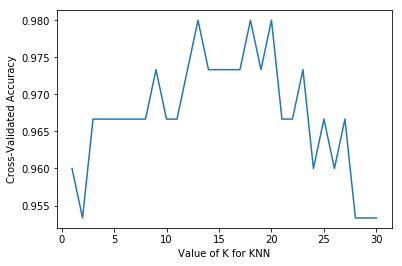

In [50]:
# plot the results
plt.plot(k_range, grid_mean_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

In [51]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.98
{'n_neighbors': 13}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=13, p=2,
           weights='uniform')


## Searching multiple parameters simultaneously

- **Example:** tuning `max_depth` and `min_samples_leaf` for a `DecisionTreeClassifier`
- Could tune parameters **independently**: change `max_depth` while leaving `min_samples_leaf` at its default value, and vice versa
- But, best performance might be achieved when **neither parameter** is at its default value

In [52]:
# define the parameter values that should be searched
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']

In [53]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range, weights=weight_options)
print(param_grid)

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance']}


In [54]:
# instantiate and fit the grid
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=20, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [55]:
# view the complete results
grid.grid_scores_

/Users/jamie/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.96000, std: 0.05333, params: {'n_neighbors': 1, 'weights': 'uniform'},
 mean: 0.96000, std: 0.05333, params: {'n_neighbors': 1, 'weights': 'distance'},
 mean: 0.95333, std: 0.05207, params: {'n_neighbors': 2, 'weights': 'uniform'},
 mean: 0.96000, std: 0.05333, params: {'n_neighbors': 2, 'weights': 'distance'},
 mean: 0.96667, std: 0.04472, params: {'n_neighbors': 3, 'weights': 'uniform'},
 mean: 0.96667, std: 0.04472, params: {'n_neighbors': 3, 'weights': 'distance'},
 mean: 0.96667, std: 0.04472, params: {'n_neighbors': 4, 'weights': 'uniform'},
 mean: 0.96667, std: 0.04472, params: {'n_neighbors': 4, 'weights': 'distance'},
 mean: 0.96667, std: 0.04472, params: {'n_neighbors': 5, 'weights': 'uniform'},
 mean: 0.96667, std: 0.04472, params: {'n_neighbors': 5, 'weights': 'distance'},
 mean: 0.96667, std: 0.04472, params: {'n_neighbors': 6, 'weights': 'uniform'},
 mean: 0.96667, std: 0.04472, params: {'n_neighbors': 6, 'weights': 'distance'},
 mean: 0.96667, std: 0.04472, para

In [56]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.98
{'n_neighbors': 13, 'weights': 'uniform'}


## Using the best parameters to make predictions

In [57]:
# train your model using all data and the best known parameters
knn = KNeighborsClassifier(n_neighbors=13, weights='uniform')
knn.fit(X, y)

# make a prediction on out-of-sample data
knn.predict([[3, 5, 4, 2]])

array([1])

In [58]:
# shortcut: GridSearchCV automatically refits the best model using all of the data
grid.predict([[3, 5, 4, 2]])

array([1])

In [59]:
knn.classes_

array([0, 1, 2])

# Applying the ML workflow step-by-step

We will apply the techniques discussed above to the Pima Indians Diabetes dataset.  The dataset contains various diagnostic measurements for women of Pima Indiana heritage.  Our goal is to determine whether each woman has diabetes or not based on the available medical information.


| Attribute | Value |
|------------|------|
|Pima Indians dataset | The data can be found in the "datasets" folder inside the Lab02 folder |
|Problem description| Determine whether an individual has diabetes based on available medical data|
|Data engineering | Split the data and generate splits for cross-fold validation|
|Feature engineering | Standardize the numerical data
|Approaches to be explored| Explore KNN for classification, identify best hyperparameters|
|Generate predictions | Evaluate the best model using test data|


## Load the data

In [60]:
import pandas as pd
import numpy as np

pima = pd.read_csv('datasets/Pima-Diabetes/diabetes.csv')

## Understand the data (e.g., review data dictionary, EDA "light")

### Review a data dictionary (when available)

The data available to us includes: 

|Feature|Meaning|
---------|---------
Pregnancies|Number of times pregnant
Glucose|Plasma glucose concentration
BloodPressure|Diastolic blood pressure (mm Hg)
SkinThickness|Triceps skin fold thickness (mm)
Insulin|2-Hour serum insulin (mu U/ml)
BMI|Body mass index (weight in kg/(height in m)^2)
DiabetesPedigreeFunction|Calculation based on diabetes history in relatives
Age|Age (years)

The `'outcome'` feature is our target classification variable denoting whether a person has diabetes (Class 1) or not (Class 0).

### Explore counts, datatypes, NaN values, and basic descriptive statistics

In [61]:
pima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [62]:
pima.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [63]:
pima.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


### Visualize extent of correlation between features

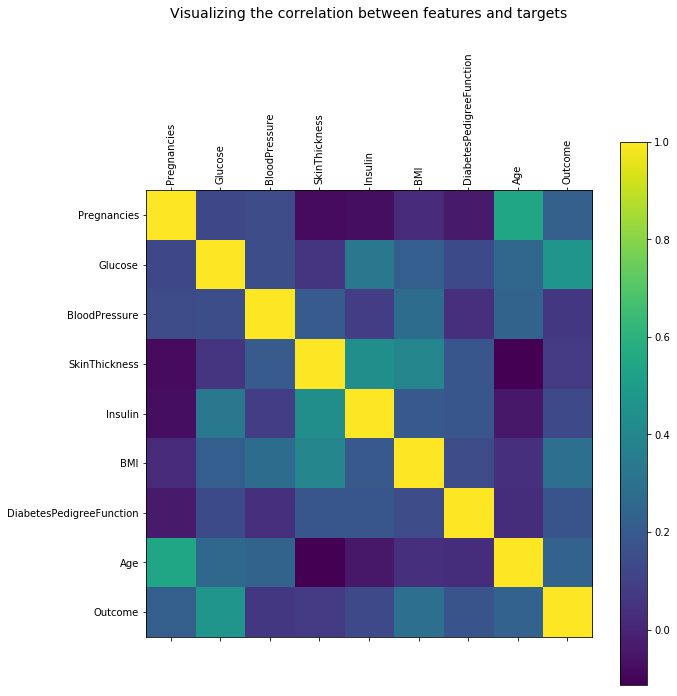

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ms = ax.matshow(pima.corr())
fig.colorbar(ms)
label_count = list(range(len(pima.columns)))
ax.set_xticks(label_count)
ax.set_xticklabels(pima.columns, rotation=90)
ax.set_yticks(label_count)
ax.set_yticklabels(pima.columns)
ax.set_title('Visualizing the correlation between features and targets', pad=150, fontsize=14);

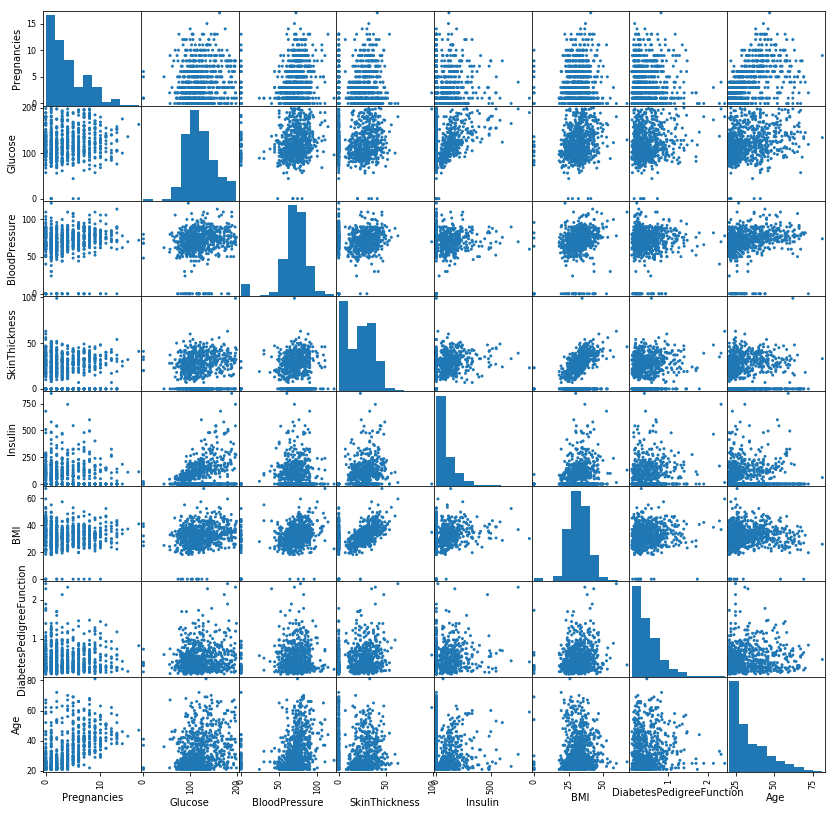

In [65]:
pd.plotting.scatter_matrix(pima.iloc[:,:-1], alpha=1, figsize=(14,14));

## Data engineering (e.g., split data)

### Assign feature values to X and targets to y

In [66]:
X = pima.iloc[:,:-1]
y = pima.iloc[:,-1]

### Separate data into training set and and hold-out test set

In [67]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

In [68]:
print('X_train:', len(X_train), '\ty_train:', len(y_train), '\tClass 1 Proportion:',round(np.mean(y_train),3))
print('X_test:', len(X_test), '\ty_test:', len(y_test), '\tClass 1 Proportion:',round(np.mean(y_test),3))

X_train: 614 	y_train: 614 	Class 1 Proportion: 0.349
X_test: 154 	y_test: 154 	Class 1 Proportion: 0.351


### Generate splits for training data

In [69]:
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

## Feature engineering (e.g., standardize features)
Use StandardScaler to center data around mean of 0 and standard deviation of 1.

In [70]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [71]:
# first five samples before scaling
print(X_train.values[0:5])

[[  1.     90.     62.     12.     43.     27.2     0.58   24.   ]
 [  5.    126.     78.     27.     22.     29.6     0.439  40.   ]
 [  2.    105.     58.     40.     94.     34.9     0.225  25.   ]
 [  1.    146.     56.      0.      0.     29.7     0.564  29.   ]
 [  0.     95.     64.     39.    105.     44.6     0.366  22.   ]]


In [72]:
# first five samples after scaling
print(X_train_scaled[0:5])

[[-0.85135507 -0.98013068 -0.40478372 -0.55397256 -0.33131928 -0.60767846
   0.31079384 -0.79216928]
 [ 0.35657564  0.16144422  0.46536842  0.392787   -0.52639809 -0.30213902
  -0.11643851  0.56103382]
 [-0.5493724  -0.50447447 -0.62232176  1.21331196  0.14244354  0.3725939
  -0.76486207 -0.70759409]
 [-0.85135507  0.7956525  -0.73109078 -1.31138021 -0.73076636 -0.28940821
   0.26231357 -0.36929331]
 [-1.15333775 -0.82157861 -0.29601471  1.15019465  0.24462767  1.60748245
  -0.33762972 -0.96131967]]


## Modeling (hypothesis, baseline)

In [73]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import time
knn = KNeighborsClassifier()
start = time.time()
knn_cv = cross_val_score(knn, X_train, y_train, cv=kfold)
duration = time.time()-start

In [74]:
results = pd.DataFrame(columns = ['Model', 'Accuracy', 'Run Time (ms)'])
results.loc[len(results)] = ['KNN (default)', knn_cv.mean(), round(duration*1000, 3)]
results

,Model,Accuracy,Run Time (ms)
0,KNN (default),0.713458,34.25


## Hyperparameter tuning

### Explore hyperparameter outcomes manually

In [75]:
# Provide X, and Y and run this cell 

from sklearn.cross_validation import cross_val_score
from sklearn.pipeline import Pipeline
# search for an optimal value of K for KNN

# range of k we want to try
k_range = range(1, 31)
# empty list to store scores
k_scores = []
# create pipeline

# we will loop through reasonable values of k
for k in k_range:
    # create pipeline
    estimators = [] 
    estimators.append(('standardize', StandardScaler()))# standardize the data
    estimators.append(('knn', KNeighborsClassifier(n_neighbors=k)))
    model = Pipeline(estimators)
    # evaluate pipeline
    seed = 7
    #kfold = KFold(n_splits=10, random_state=seed)
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    # 4. append mean of scores for k neighbors to k_scores list
    k_scores.append(scores.mean())

print(k_scores)

[0.7263352723426757, 0.7150713907985192, 0.7314119513484929, 0.7296932839767318, 0.7328133262823903, 0.7313061872025384, 0.7475409836065574, 0.7507667900581703, 0.762083553675304, 0.7540719196192489, 0.7524590163934426, 0.7590428344791116, 0.7557905869910101, 0.7590957165520889, 0.7623215230037017, 0.7589899524061343, 0.7525383395029085, 0.7574034902168164, 0.7475674246430459, 0.7622421998942358, 0.749206768905341, 0.7557377049180328, 0.7573770491803279, 0.7541248016922264, 0.7540983606557377, 0.7524061343204653, 0.757297726070862, 0.7638551031200423, 0.7574563722897938, 0.7556848228450554]


Text(0,0.5,'Cross-validated accuracy')

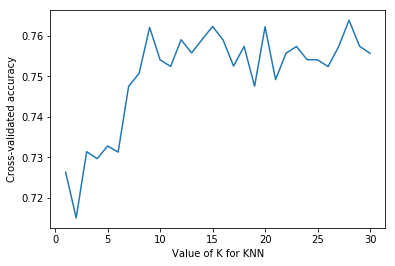

In [76]:
# plot how accuracy changes as we vary k
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
# plt.plot(x_axis, y_axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-validated accuracy')

### Use grid search to find the best hyperparameter combination

Machine learning models are parameterized so that their behavior can be tuned for a given problem. Models can have many parameters and finding the best combination of parameters can be treated as a search problem. In this section you will discover how to tune the parameters of machine learning algorithms in Python using the scikit-learn.

Grid search is an approach to parameter tuning that will methodically build and evaluate a model for each combination of algorithm parameters specified in a grid. You can perform a grid search using GridSearchCV.

In [77]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors': list(range(1,21)),
          'weights': ['uniform', 'distance'],
          'p': list(range(1,11))}
knn_gs = GridSearchCV(knn, params, n_jobs=-1, cv=5, verbose=1)
knn_gs.fit(X_train, y_train)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Done 268 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    5.3s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'weights': ['uniform', 'distance'], 'p': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

### Evaluate model using best combination

In [78]:
knn = knn_gs.best_estimator_
start = time.time()
knn_cv = cross_val_score(knn, X_train, y_train, cv=30)
duration = time.time()-start

In [79]:
results.loc[len(results)] = ['KNN (grid search)', knn_cv.mean(), round(duration*1000, 3)]
results

,Model,Accuracy,Run Time (ms)
0,KNN (default),0.713458,34.250
1,KNN (grid search),0.757201,113.357


## Evaluate model using held-out test data

In [80]:
from sklearn.metrics import accuracy_score
knn = knn_gs.best_estimator_
start = time.time()
y_preds = knn.predict(X_test)
score = accuracy_score(y_test, y_preds)
duration = time.time()-start

In [81]:
results.loc[len(results)] = ['KNN (best model test)', score, round(duration*1000, 3)]
results

,Model,Accuracy,Run Time (ms)
0,KNN (default),0.713458,34.250
1,KNN (grid search),0.757201,113.357
2,KNN (best model test),0.701299,2.381


# Using pipelines for a machine learning workflow

In Python scikit-learn, Pipelines can help to define and automate workflows. In this section, we will rework the step-by-step workflow above using Pipelines in sci-kit learn, and you will discover how you can automate a common machine learning workflow.

## Pipeline Example: Data Preparation and Modeling

An easy trap to fall into in applied machine learning is leaking data from your training dataset to your test dataset.

To avoid this trap you need a robust test harness with strong separation of training and testing. This includes data preparation.

Data preparation is one easy way to leak knowledge of the whole training dataset to the algorithm. For example, preparing your data using normalization or standardization on the entire training dataset before learning would not be a valid test because the training dataset would have been influenced by the scale of the data in the test set.

Pipelines help you prevent data leakage in your test harness by ensuring that data preparation like standardization is constrained to each fold of your cross validation procedure.

The example below demonstrates this important data preparation and model evaluation workflow. The pipeline is defined with two steps:

1. Standardize the data.
* Use grid search to identify a best model using cross-fold validation.

In [83]:
# Create a pipeline that standardizes the data then creates a model
from pandas import read_csv
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

pima = pd.read_csv('datasets/Pima-Diabetes/diabetes.csv')
X = pima.iloc[:,:-1]
y = pima.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {'knn__n_neighbors': list(range(1,21)),
          'knn__weights': ['uniform', 'distance'],
          'knn__p': list(range(1,11))}
model = Pipeline([('standardize', StandardScaler()),
                  ('knn', KNeighborsClassifier())
                 ])
knn_gs = GridSearchCV(model, params, cv=5, refit=True, verbose=1,)
knn_gs.fit(X_train, y_train)
y_preds = knn_gs.best_estimator_.predict(X_test)
score = accuracy_score(y_test, y_preds)

print("Best model:", knn_gs.best_estimator_)
print("Test accuracy:", score)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits
Best model: Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=13, p=1,
           weights='distance'))])
Test accuracy: 0.7012987012987013


[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  1.1min finished


## Task: Use a pipeline for Hyperparameter tuning for KNN via crossfold validation

Using the previous section(s) as guidance, apply a pipeline workflow **on the Wine Quality dataset**.

In the case of each data set:

* Determine the optimal value of K for a KNN classifier for the wine quality dateset using N-fold cross validation when n=10.
* What is the optimal value of K. Report the performance of accuracy on the held out test dataset.
* Please feel free to adopt the following code for this task.

In [89]:
from sklearn.datasets import load_wine
wine = load_wine()
print(wine.DESCR)

Wine Data Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 178 (50 in each of three classes)
    :Number of Attributes: 13 numeric, predictive attributes and the class
    :Attribute Information:
 		- 1) Alcohol
 		- 2) Malic acid
 		- 3) Ash
		- 4) Alcalinity of ash  
 		- 5) Magnesium
		- 6) Total phenols
 		- 7) Flavanoids
 		- 8) Nonflavanoid phenols
 		- 9) Proanthocyanins
		- 10)Color intensity
 		- 11)Hue
 		- 12)OD280/OD315 of diluted wines
 		- 13)Proline
        	- class:
                - class_0
                - class_1
                - class_2
		
    :Summary Statistics:
    
    ============================= ==== ===== ======= =====
                                   Min   Max   Mean     SD
    ============================= ==== ===== ======= =====
    Alcohol:                      11.0  14.8    13.0   0.8
    Malic Acid:                   0.74  5.80    2.34  1.12
    Ash:                          1.36  3.23    2.36  0.27
    Alcalinity of Ash: 

In [90]:
X = wine.data
y = wine.target

## More about Grid Search

We hypertune the following parameters:

* Best K
* weight/uniform

This code performs  a two-dimensional grid search to determine the optimal combination of hyperparameters for the Pima-Indian Diabetes binary classifiction problem. It means that we will do thirty (30) experiments (15 by 2 combinations), where are doing 5-fold cross validation (`cv=5`). Overall, that means we are build 150 models, and we test each of these on the held out fold. 

In [91]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [92]:
# Grid Search for Algorithm Tuning

parameters = [{'knn__n_neighbors': list(range(1,16)),
               'knn__weights':['uniform', 'distance'],
              }]

pipe = Pipeline([
    ('standardize', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

grid_search = GridSearchCV(pipe, parameters, cv=5, refit=True)
grid_search.fit(X_train, y_train)
print(grid_search.best_score_)
print(grid_search.best_estimator_)

0.758957654723127
Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('knn', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=11, p=2,
           weights='distance'))])


In [93]:
from sklearn.preprocessing import Normalizer
print("All GRID results\n-----------------------------------------------")
cvres = grid_search.cv_results_
#cvres is a results data structure. PRINT it!  print(cvres)
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("GRID", mean_score, params)
print("\nAll GRID results\n-----------------------------------------------")
#print("grid_search.cv_results_", grid_search.cv_results_)
#estimator : estimator object. This is assumed to implement the scikit-learn estimator interface.  
#            Either estimator needs to provide a score function, or scoring must be passed.
#Accuracy is the default for classification; feel free to change this to precision, recall, fbeta
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(grid_search.best_params_.keys()):
    print("\t%s: %r" %(param_name, best_parameters[param_name]))

All GRID results
-----------------------------------------------
GRID 0.7182410423452769 {'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
GRID 0.7182410423452769 {'knn__n_neighbors': 1, 'knn__weights': 'distance'}
GRID 0.7214983713355049 {'knn__n_neighbors': 2, 'knn__weights': 'uniform'}
GRID 0.7182410423452769 {'knn__n_neighbors': 2, 'knn__weights': 'distance'}
GRID 0.7312703583061889 {'knn__n_neighbors': 3, 'knn__weights': 'uniform'}
GRID 0.7263843648208469 {'knn__n_neighbors': 3, 'knn__weights': 'distance'}
GRID 0.7263843648208469 {'knn__n_neighbors': 4, 'knn__weights': 'uniform'}
GRID 0.744299674267101 {'knn__n_neighbors': 4, 'knn__weights': 'distance'}
GRID 0.744299674267101 {'knn__n_neighbors': 5, 'knn__weights': 'uniform'}
GRID 0.741042345276873 {'knn__n_neighbors': 5, 'knn__weights': 'distance'}
GRID 0.757328990228013 {'knn__n_neighbors': 6, 'knn__weights': 'uniform'}
GRID 0.739413680781759 {'knn__n_neighbors': 6, 'knn__weights': 'distance'}
GRID 0.7361563517915309 {'knn__n_n

## Grid search object contains a lot of information.
Go ahead and explore.

In [94]:
print(grid_search.best_params_)

{'knn__n_neighbors': 11, 'knn__weights': 'distance'}


In [95]:
print(grid_search.cv_results_.keys())

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_knn__n_neighbors', 'param_knn__weights', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])


In [96]:
print(grid_search.cv_results_)

{'mean_fit_time': array([0.00198207, 0.00190916, 0.00222096, 0.00229888, 0.00209289,
       0.00186791, 0.00146208, 0.00150809, 0.00137239, 0.00139308,
       0.00133801, 0.00134325, 0.00141697, 0.00137191, 0.00136585,
       0.00142627, 0.00185962, 0.00203938, 0.00214667, 0.00229607,
       0.00202775, 0.00142708, 0.00134974, 0.00132704, 0.00143661,
       0.00155563, 0.00149274, 0.00141587, 0.00136518, 0.00154209]), 'std_fit_time': array([7.82975616e-05, 8.11232450e-05, 4.06066797e-04, 8.41915926e-05,
       1.50865158e-04, 1.76939010e-04, 6.19058053e-05, 2.27963303e-04,
       5.30167873e-05, 4.83257463e-05, 1.88733569e-05, 3.93131922e-05,
       6.06326901e-05, 5.46519457e-05, 5.89349123e-05, 1.34389462e-04,
       2.71857422e-04, 9.56549364e-05, 1.52432646e-04, 1.57293871e-04,
       2.38719512e-04, 5.73301456e-05, 5.51753136e-05, 1.86436621e-05,
       1.26613025e-04, 3.11062899e-04, 1.45184504e-04, 1.22504709e-04,
       4.66423769e-05, 3.61964414e-04]), 'mean_score_time': array

# Gridsearch for KNN regression

## Utility maximization via Gridsearch (maximize utility == minimize MSE)

### Minimize MSE is equivalent to maximizing (-MSE)
Grid search will use cross_val_score based on maximizing a utility performance measure. So we maximize utility means `maximizing(-MSE)` for a regression problem where our goal is to minimize the MSE (mean squared error).

A similar argument applies to GridSearchCV (which uses cross_val_score at its core).

[cross_val_score](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)

In [97]:
from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np
lin_reg = LinearRegression()

boston = load_boston()
print("Data shape: {}".format(boston.data.shape))
X = boston.data
y = boston.target
# minimize(mean_squared_error) is equivalent to maximize(neg_mean_squared_error)
lin_scores = cross_val_score(lin_reg, X, y,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
print(lin_rmse_scores)

Data shape: (506, 13)
[ 3.0498042   3.76458281  3.75583699  5.93252006  5.65019905  4.45629184
  3.15561721 12.98193946  5.7980961   3.31157714]


## Task KNN regression model for the Boston housing data

Using SKLearn's implemention of KNN, determine a good KNN regression model for the Boston housing data.  Use RMSE (root mean squared error) as the performance metric for hyperparameter tuning. Dont forget to use the negative of RMSE during gridsearch!

The code to import this data is provided below. You will need to split the data appropriately (training and heldout  for the task.

Also, you can use the grid search code provided in the previous questions. There is no need to modify any code, but try to reconfigure the pipeline and gridsearch as follows:

* Change the KNN estimator from a Classifier to a Regressor.
* Add an additional hyperparameter (p) to the gridsearch. Try values 1 (Manhattan) or 2 (Euclidean) distance. 

Finally, please report test RMSE of the best configuration as determined by gridsearch in terms of a number within 2 decimal places. e.g, an RMSE of 0.8134 as produced by gridsearch should be reported as 0.81. Please use np.round(rmse, 2).

In [98]:
from sklearn.datasets import load_boston
boston = load_boston()
print("Data shape: {}".format(boston.data.shape))

Data shape: (506, 13)


In [99]:
# Uncomment and run the line below to learn more about the Boston dataset
# print(boston.DESCR)

In [100]:
X = boston.data
y = boston.target

In [ ]:
# split the data into training and a heldout (aka blind) test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# define parameter grid

# Configure the pipeline (standardize the data; build model)

# Set up gridsearch with crossfold validation

# examine results of grid search

# use the best model to compute metrics on the heldout test set